In [1]:
import numpy as np
import scipy.stats as si
import pandas as pd
import torch

In [14]:
datasize = 50000
learning_rate = 0.0001

b_size = 100
epoch = 20

In [15]:
# BSM model for option pricing

def euro_option(S0, K, T, r, sigma, option_type):
    
    #S0: stock price
    #sigma: volatility
    #K: strike price
    #r: return
    #T: time to maturity
    
    d1 = (np.log(S0/K) + (r + sigma ** 2 * 0.5))/sigma/np.sqrt(T)
    d2 = (np.log(S0/K) + (r - sigma ** 2 * 0.5))/sigma/np.sqrt(T)
    
    if option_type == 'call':
        price = S0 * si.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * si.norm.cdf(d2, 0, 1)
        
    if option_type == 'put':
        price = K * np.exp(-r * T) * si.norm.cdf(-d2, 0, 1) - S0 * si.norm.cdf(-d1, 0, 1)
        
    return price

In [16]:
def simulate_price(total_num):
    np.random.seed(42)
    S0 = np.random.rand(total_num) * 100
    K = np.random.randint(50,150,total_num)* 0.01 * S0
    T = np.random.randint(10, 300, total_num)/100
    r = np.random.randint(1, 1000, total_num)/10000
    sigma = np.random.randint(1, 50, total_num)/100
    option_type = np.random.choice(['call','put'], total_num)
    
    option_price_list = []
    
    for i in range(total_num): 
        price = euro_option(S0[i], K[i], T[i], r[i], sigma[i], option_type[i])
        option_price_list.append(price)
        if i%100000 == 1:
            print('finished:', i)
            
    df = pd.DataFrame({'S0': S0,
                       'K': K,
                       'T': T,
                       'r': r,
                       'sigma': sigma,
                       'option_type': option_type,
                       'price': option_price_list})
    return df

In [17]:
df = simulate_price(datasize)

finished: 1


In [18]:
from sklearn.model_selection import train_test_split
df_coded = pd.concat([df, pd.get_dummies(df['option_type'])], axis=1).drop(columns='option_type')
df_coded = df_coded[['S0','K','T','r','sigma','call','put','price']]

In [19]:
train_set, test_set = train_test_split(df_coded, test_size=0.1)


In [20]:
# define dataset
from torch.utils.data import Dataset, DataLoader

class option_dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = torch.tensor(dataset.values)
    def __getitem__(self, index):
        return (self.dataset[:,0:7][index], self.dataset[:,7][index].view(1))
    def __len__(self):
        return self.dataset.shape[0]
    

    
train_dataset = option_dataset(train_set)
test_dataset = option_dataset(test_set)

In [21]:
train_loader = DataLoader(train_dataset, batch_size = b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = b_size, shuffle=True)

In [22]:
# define NN
import torch.nn as nn
import torch.nn.functional as F
class option_pricing(nn.Module):
    
    def __init__(self):
        super(option_pricing,self).__init__()
        self.fc1 = nn.Linear(7, 128)
        self.fc2 = nn.Linear(128, 1024)
        self.fc3 = nn.Linear(1024, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
net = option_pricing()

In [23]:
import  torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9 )

In [24]:
train_loss_list = []
test_loss_list = []
for epoch in range(epoch):
    
    train_running_loss = []
    test_running_loss = []
    
    print('Train:')
    for i, data in enumerate(train_loader):
        inputs,target = data

        #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)
        optimizer.zero_grad()
        outputs = net(inputs.float())
        loss = criterion(outputs, target.float())
        loss.backward()
        optimizer.step()
        
        
        
        train_running_loss.append(loss.item()/b_size)
         
        if i%1000 == 0:
            print('epoch {}, batches {}, running_loss {}'.format(epoch+1, i+1, loss.item()/b_size))
          
            
    train_loss_list.append(np.mean(train_running_loss))
            
        
            
           
    for j, data2 in enumerate(test_loader):
        test_inputs, test_target = data2
        test_outputs = net(test_inputs.float())
        loss_test = criterion(test_outputs, test_target.float())
        test_running_loss.append(loss_test.item()/b_size)
        
    print('Test:')
    print('running_loss_ave:', np.mean(test_running_loss))
        
    test_loss_list.append(np.mean(test_running_loss))  
    print('------------') 
            
print('Finished') 

Train:
epoch 1, batches 1, running_loss 1.3982667541503906
Test:
running_loss_ave: 0.8192487121582032
------------
Train:
epoch 2, batches 1, running_loss 0.7787499237060547
Test:
running_loss_ave: 0.8872255165100097
------------
Train:
epoch 3, batches 1, running_loss 0.7977737426757813
Test:
running_loss_ave: 0.6817397193908691
------------
Train:
epoch 4, batches 1, running_loss 0.4826042556762695
Test:
running_loss_ave: 0.7391949226379394
------------
Train:
epoch 5, batches 1, running_loss 0.7300798797607422
Test:
running_loss_ave: 0.7792520690917969
------------
Train:
epoch 6, batches 1, running_loss 0.6050587463378906
Test:
running_loss_ave: 0.7883411018371581
------------
Train:
epoch 7, batches 1, running_loss 1.063653793334961
Test:
running_loss_ave: 0.529281958770752
------------
Train:
epoch 8, batches 1, running_loss 0.4487264633178711
Test:
running_loss_ave: 0.8550063377380371
------------
Train:
epoch 9, batches 1, running_loss 0.8195243072509766
Test:
running_loss_ave:

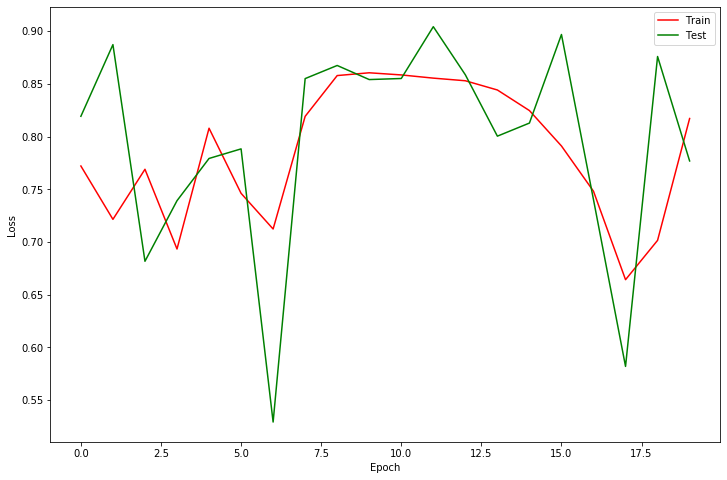

In [25]:
# Plot

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(train_loss_list, c='r', label = 'Train')
plt.plot(test_loss_list, c='g', label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()